In [1]:
import shutil
import subprocess
import tempfile
import os

from tqdm.notebook import tqdm

import pandas as pd
import matplotlib.pyplot as plt

import biolqm

This notebook has been executed using the docker image `colomoto/colomoto-docker:2021-02-01`

In [2]:
model = "covert"
pipeline = "nbi"

In [3]:
metabolic_network = f"data/{model}/metabolic_network.xml"
regulatory_network = f"data/{model}/regulatory_network.sbml"

In [4]:
lqm = biolqm.load(regulatory_network)
bn = biolqm.to_minibn(lqm)
bn

Carbon1 <- 0
Hext <- 0
Oxygen <- 0
R2a <- !RPb
R2b <- 0
R5a <- !RPO2
R5b <- RPO2
R7 <- !RPb
R8a <- !RPh
RPO2 <- !Oxygen
RPb <- R2b
RPcl <- Carbon1
RPh <- Hext
Rres <- !RPO2
Tc2 <- !RPcl

In [5]:
regulators = {'RPO2', 'RPb', 'RPcl', 'RPh'}

In [6]:
constraints = """\
obj : MAX(Growth)


Tc1 0 10.5
Tc2 0 10.5
Td 0 12
Te 0 12
Tf 0 5
Th 0 5
To2 0 15
"""

initParams = {
    "biomassReaction": "Growth",
    "timeStep": "0.01",
    "nSteps": 300,
    "initBiomass": "0.01"
}

initConcentrations = {
    "Carbon1": 10,
    "Carbon2": 10,
    "Hext": 0,
    "Dext": 0,
    "Eext": 0,
    "Fext": 0,
    "Oxygen": 100,
    "Biomass": 0
}

default = {
    "constraints": constraints,
    "initParams": initParams,
    "initConcentrations": initConcentrations,
}

simulations = {
    "fig5": default,
    "fig6": default | {"initConcentrations": initConcentrations | {
        "Carbon1": 0,
        "Oxygen": 5,
    }},
    "fig7": default | {"initConcentrations": initConcentrations | {
        "Carbon1": 0,
        "Hext": 2,
    }},
    "fig8": default | {"initConcentrations": initConcentrations | {
        "Carbon1": 0,
        "Carbon2": 5,
        "Hext": 10,
    }},
    "fig9": default | {"initConcentrations": initConcentrations | {
        "Carbon1": 1,
        "Hext": 5,
        "Fext": 0.1,
    }},
}

### Automatically set initial value of regulatory nodes

In [7]:
def auto_initReg(x0):
    return {i:v for i,v in bn(x0).items() if v == 1 and i in regulators}

In [8]:
for cfg in simulations.values():
    initReg = auto_initReg(cfg["initConcentrations"])
    if initReg:
        cfg["initRegStates"] = initReg

### Simulations

In [9]:
def met4j_dynamicRFBA(mn, rn, cons, init, output):
    subprocess.run(["java", "-Dlog4j.configuration=",
        "-jar", "/opt/met4j-dynamicRFBA.jar",
        "-sol", "GLPK", 
        "-s", mn, "-reg", rn,
        "-cons", cons, "-init", init, "-out", output], check=True)

In [10]:
output_dir = f"data/{model}/result/pipeline_{pipeline}/FlexFlux"
output_tmpl = "out_times-{}.csv"
if os.path.isdir(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

In [11]:
def write_constraints(cfg, filename):
    with open(filename, "w") as fp:
        fp.write(cfg["constraints"])

def _write_state(fp, sect, state):
    fp.write(f"{sect}\n")
    for node, value in state.items():
        fp.write(f"{node}\t{value}\n")
        
def write_initial(cfg, filename):
    with open(filename, "w") as fp:
        for sect, value in cfg["initParams"].items():
            fp.write(f"{sect}\n{value}\n\n")
        sect = "initConcentrations"
        _write_state(fp, sect, cfg[sect])
        sect = "initRegStates"
        if sect in cfg:
            fp.write("\n")
            _write_state(fp, sect, cfg[sect])

In [12]:
def read_simulation(out):
    df = pd.read_csv(out, sep="\t")
    df.set_index("Time", inplace=True)
    return df

def plot_simulation(df, **kwargs):
    df = df.drop(["Oxygen"], axis=1)
    return df.plot(title=f"Simulation {name}", **kwargs)

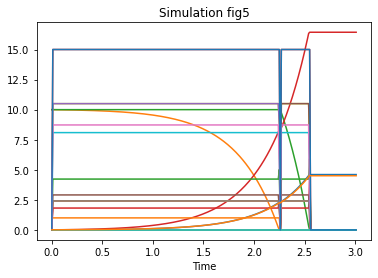

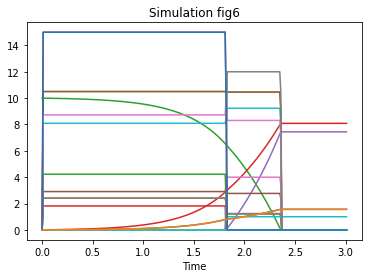

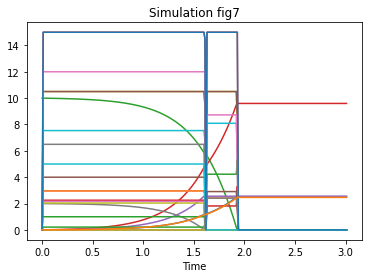

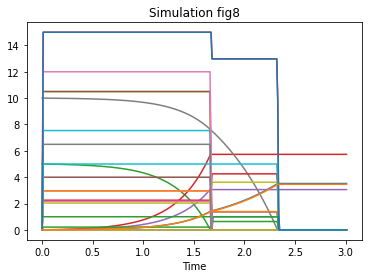

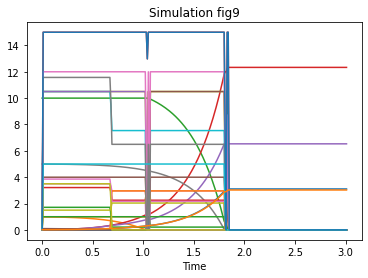

In [13]:
%matplotlib inline
output = {}
for name, cfg in tqdm(simulations.items()):
    out = os.path.join(output_dir, output_tmpl.format(name))
    cons = os.path.join(output_dir, f"constraints-{name}.txt")
    init = os.path.join(output_dir, f"initialParameters-{name}.txt")
    write_constraints(cfg, cons)
    write_initial(cfg, init)
    met4j_dynamicRFBA(metabolic_network, regulatory_network, cons, init, out)
    output[name] = read_simulation(out)
    plt.show(plot_simulation(output[name], legend=False))